<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/Classification/ES_SVM_Heart_Disease_Classification_Ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# -----------------------------
# Import libraries
# -----------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.utils import check_random_state

from imblearn.over_sampling import SMOTE

# -----------------------------
# Load dataset
# -----------------------------
data_path = 'ClevelandDataSet.xlsx'
df = pd.read_excel(data_path)

# -----------------------------
# Group numeric features
# -----------------------------
def group_features_custom(df):
    # Age: 3 groups
    df['Age_group'] = pd.cut(df['Age'], bins=[28, 49, 64, 77],
                             labels=['Young','Middle-aged','Older'], right=True)

    # Resting Blood Pressure: 2 groups
    df['Trestbps_group'] = pd.cut(df['Trestbps'], bins=[0, 130, df['Trestbps'].max()+1],
                                  labels=['Normal','High'], right=True)

    # Cholesterol: 2 groups
    df['Chol_group'] = pd.cut(df['Chol'], bins=[0, 240, df['Chol'].max()+1],
                              labels=['Normal/Borderline','High'], right=True)

    # Max Heart Rate: 2 groups
    df['Thalach_group'] = pd.cut(df['Thalach'], bins=[0, 140, df['Thalach'].max()+1],
                                 labels=['Low','High'], right=True)

    return df

df = group_features(df)
group_features_list = ['Age_group','Trestbps_group','Chol_group','Thalach_group','Oldpeak_group']

# -----------------------------
# Create output directory for plots
# -----------------------------
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# -----------------------------
# EDA: distributions & plots
# -----------------------------
for feature in group_features_list:
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x=feature, hue='Class')
    plt.title(f'{feature} distribution by Class')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Class')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir,f"{feature}_distribution.png"))
    plt.close()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[['Age','Trestbps','Chol','Thalach','Oldpeak','Class']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig(os.path.join(output_dir,"correlation_heatmap.png"))
plt.close()

# Pairplot
pairplot = sns.pairplot(df[['Age','Trestbps','Chol','Thalach','Oldpeak','Class']], hue='Class', diag_kind='kde', corner=True)
pairplot.fig.suptitle("Pairplot of Numeric Features by Class", y=1.02)
pairplot.savefig(os.path.join(output_dir,"pairplot_numeric_features.png"))
plt.close()

In [46]:
# -----------------------------
# Prepare data for SVM
# -----------------------------
df['CHD_binary'] = (df['Class'] != 0).astype(int)
X = df[group_features_list]
y = df['CHD_binary']

# One-hot encode categorical features
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = ohe.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=23, stratify=y)

# SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Gen 1/50 - Best: 0.7191, Avg: 0.5890
Gen 10/50 - Best: 0.7229, Avg: 0.6772
Gen 20/50 - Best: 0.7229, Avg: 0.6871
Gen 30/50 - Best: 0.7187, Avg: 0.6825
Gen 40/50 - Best: 0.7229, Avg: 0.7010
Gen 50/50 - Best: 0.7268, Avg: 0.7054


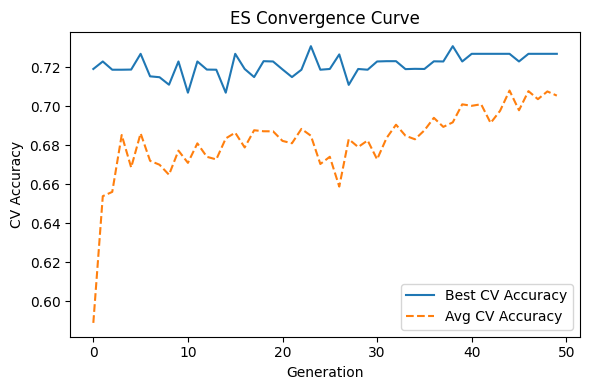


Best C: 178.390080, Best gamma: 0.421230, Best CV accuracy: 0.7308


,accuracy,precision,recall,f1
train,0.863281,0.911504,0.804688,0.854772
test,0.633333,0.650000,0.464286,0.541667


In [47]:
# -----------------------------
# Evolution Strategies (ES) optimization
# -----------------------------
def evaluate_candidate(logC, logGamma, X, y, cv=5, random_state=0):
    C, gamma = 10**logC, 10**logGamma
    svm = SVC(kernel='rbf', C=C, gamma=gamma, probability=False, random_state=random_state)
    cv_split = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    return cross_val_score(svm, X, y, cv=cv_split, scoring='accuracy', n_jobs=-1).mean()

def evolution_strategies(X, y, pop_size=20, generations=50, sigma_init=(0.5,0.5),
                         logC_bounds=(-3,3), logG_bounds=(-5,2), elite_frac=0.2, random_seed=23):
    rng = check_random_state(random_seed)
    mu = int(np.ceil(pop_size * (1 - elite_frac)))
    pop = np.column_stack([rng.uniform(*logC_bounds,pop_size), rng.uniform(*logG_bounds,pop_size)])
    sigma = np.array(sigma_init)
    best_history, avg_history = [], []
    best_individual, best_score = None, -np.inf

    for g in range(generations):
        fitness = np.array([evaluate_candidate(ind[0], ind[1], X, y) for ind in pop])
        idx_sorted = np.argsort(-fitness)
        pop, fitness = pop[idx_sorted], fitness[idx_sorted]

        if fitness[0] > best_score:
            best_score = fitness[0]
            best_individual = pop[0].copy()

        best_history.append(fitness[0])
        avg_history.append(fitness.mean())

        parents = pop[:mu]
        parent_mean = parents.mean(axis=0)
        offspring = parent_mean + rng.normal(0, sigma, size=(pop_size,2))
        offspring[:,0] = np.clip(offspring[:,0], *logC_bounds)
        offspring[:,1] = np.clip(offspring[:,1], *logG_bounds)
        sigma = sigma*0.99 + 0.01*np.abs(rng.normal(size=sigma.shape))
        pop = offspring

        if (g+1)%10==0 or g==0:
            print(f"Gen {g+1}/{generations} - Best: {fitness[0]:.4f}, Avg: {fitness.mean():.4f}")

    # Plot convergence
    plt.figure(figsize=(6,4))
    plt.plot(best_history,label='Best CV Accuracy')
    plt.plot(avg_history,label='Avg CV Accuracy',linestyle='--')
    plt.xlabel('Generation'); plt.ylabel('CV Accuracy'); plt.title('ES Convergence Curve'); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(output_dir,"es_convergence_curve.png")); plt.show()

    return {'best_logC': best_individual[0], 'best_logGamma': best_individual[1],
            'best_score': best_score, 'history_best': best_history, 'history_avg': avg_history}

# Run ES
es_result = evolution_strategies(X_train_smote, y_train_smote, pop_size=20, generations=50, sigma_init=(0.6,0.6))

best_C, best_gamma = 10**es_result['best_logC'], 10**es_result['best_logGamma']
print(f"\nBest C: {best_C:.6f}, Best gamma: {best_gamma:.6f}, Best CV accuracy: {es_result['best_score']:.4f}")

# -----------------------------
# Train final SVM
# -----------------------------
final_svm = SVC(kernel='rbf', C=best_C, gamma=best_gamma, probability=True, random_state=42)
final_svm.fit(X_train_smote, y_train_smote)
y_train_pred = final_svm.predict(X_train_smote)
y_test_pred = final_svm.predict(X_test)

# Metrics function
def compute_metrics(y_true, y_pred):
    return {'accuracy': accuracy_score(y_true,y_pred),
            'precision': precision_score(y_true,y_pred),
            'recall': recall_score(y_true,y_pred),
            'f1': f1_score(y_true,y_pred)}

metrics_df = pd.DataFrame([compute_metrics(y_train_smote,y_train_pred),
                           compute_metrics(y_test,y_test_pred)], index=['train','test'])
metrics_df

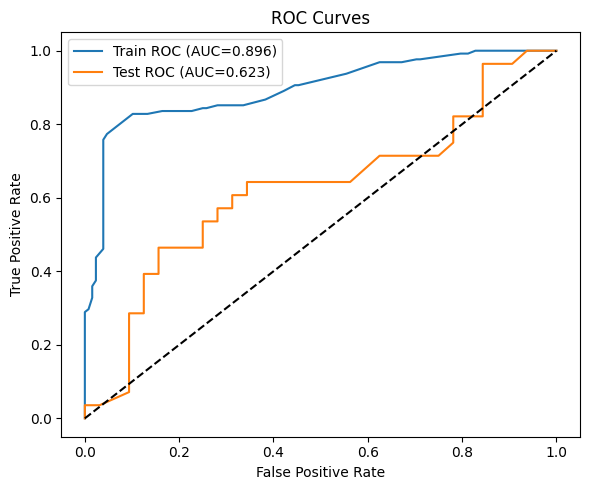


All figures saved in 'Figures' and results in 'svm_es_grouped_results'


In [48]:
# -----------------------------
# ROC curves
# -----------------------------
y_train_prob = final_svm.predict_proba(X_train_smote)[:,1]
y_test_prob = final_svm.predict_proba(X_test)[:,1]

fpr_train, tpr_train, _ = roc_curve(y_train_smote,y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test,y_test_prob)
roc_auc_train, roc_auc_test = auc(fpr_train,tpr_train), auc(fpr_test,tpr_test)

plt.figure(figsize=(6,5))
plt.plot(fpr_train,tpr_train,label=f'Train ROC (AUC={roc_auc_train:.3f})')
plt.plot(fpr_test,tpr_test,label=f'Test ROC (AUC={roc_auc_test:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(output_dir,"roc_curves.png")); plt.show()

# -----------------------------
# Save metrics & ES history
# -----------------------------
results_folder = 'svm_es_grouped_results'
os.makedirs(results_folder, exist_ok=True)
metrics_df.to_csv(os.path.join(results_folder,'metrics_train_test.csv'))
pd.DataFrame({'generation_best_cv': es_result['history_best'],
              'generation_avg_cv': es_result['history_avg']}).to_csv(os.path.join(results_folder,'es_history.csv'))

print(f"\nAll figures saved in '{output_dir}' and results in '{results_folder}'")

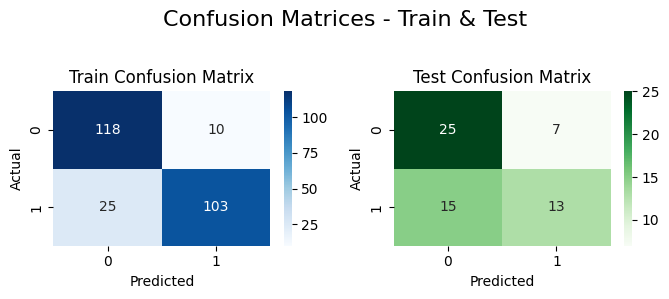

In [49]:
# -----------------------------
# Confusion matrices (train & test) in one figure
# -----------------------------
cm_train = confusion_matrix(y_train_smote, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(7,3))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.suptitle('Confusion Matrices - Train & Test', fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig(os.path.join(output_dir, 'confusion_matrices_train_test.png'))
plt.show()


In [50]:
df_grouped['CHD_binary'] = (df_grouped['Class'] != 0).astype(int)
print(df_grouped['CHD_binary'].value_counts())

CHD_binary
0    160
1    137
Name: count, dtype: int64


In [51]:
# Shape of training set after SMOTE
print("Shape of X_train_smote:", X_train_smote.shape)
print("Shape of y_train_smote:", y_train_smote.shape)

# Number of samples per class after SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Shape of X_train_smote: (256, 10)
Shape of y_train_smote: (256,)

Class distribution after SMOTE:
CHD_binary
1    128
0    128
Name: count, dtype: int64
